# One-variable Optimization of the CRM-like Box Beam

In our [last notebook](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb) we developed a straight box beam approximation of the CRM wingbox, which we called CRM-like box beam, and we studied its nonlinear structural response under a concentrated tip load. In this notebook we are going to use the OpenMDAO framework to attempt a proof-of-conpcept optimization of such box beam model including a nonlinear structural stability constraint. In this proof-of-concept optimization we are going to minimize the mass of the structure using a single design variable, that is to say the wall thickness, which will be the same for all structural elements. After recalling the CRM-like box beam geometry from our last notebook, we will define the optimization problem in a way that the initial structure is optimal in linear buckling terms, to allow an easy comparison. Then we'll implement the optimization problem with the OpenMDAO library, set up the numerical model and carry the optimization taking a look at how some nonlinear analysis parameters affect the results.

* [Definition of the CRM-like box beam model](#model-definition)
* [Formulation of the optimization problem](#optimization-problem)
* [OpenMDAO implementation](#openmdao-implementation)
* [Setup of the numerical model](#numerical-model-setup)
* [Optimization](#optimization)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # package for making plots
import tol_colors as tc  # package for colorblind-friendly colors
import os  # package for file and directory manipulation
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Set up matplotlib for interactive plotting and set default plot settings
%matplotlib widget
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures

# Set the path to the directory containing the analysis files
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(),
                                       "analyses",
                                       "19_One-variable_Optimization_of_the_CRM-like_Box_Beam")

# Define constant variables related to plotting
Z_COMPONENT_INDEX = 2  # index of z-component in load and displacement array
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
UNSTABLE_COLOR = COLORS[1]  # color for unstable segments
GLASS_CEILING_COLOR = COLORS[2]  # green is used for glass ceiling
del COLORS[1:3]  # delete red from list of colors

# Set the environment variable for the directory containing the report files
report_directory_path = os.path.relpath(ANALYSIS_DIRECTORY_PATH, os.getcwd())
os.environ['OPENMDAO_REPORTS_DIR'] = report_directory_path

## Definition of the CRM-like box beam model <a name="model-definition"></a>

***

We recall the geometrical parameters that we derived in our [last notebook](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [2]:
import numpy as np  # import numpy library

L = 29.38e3  # [mm] box beam length
W = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t0 = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates
print(f"""
Number of stiffeners: {no_stiffeners:d}
Number of ribs: {no_ribs:d}""")  # print number of stiffeners and ribs


Number of stiffeners: 2
Number of ribs: 19


We also recall the target element length that we obtained from the [mesh convergence study](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-convergence).

In [3]:
element_length = 169.6  # [mm]

Then we recall the material properties. This time we also consider the yield strength to enforce material strength constraint during the optimization. All material properties are taken from the paper by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [4]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Formulation of the optimization problem <a name="optimization-problem"></a>

***

In this notebook we want to attempt a proof-of-concept optimization with a nonlinear structural stability constraint. Given the proof-of-concept nature of our attempt, we consider only one design variable, the wall thickness $t$, which we consider to be the same for all the structural elements. We define our optimization objective as the minimization of structural mass, and we bound the wall thickness between a minimum and a maximum value.

What load magnitude should we apply to our box beam? The idea is that we should be able to compare the structure optimized with the nonlinear structural stability constraint with a baseline design that is optimal in linear buckling terms.

With the wall thickness being our only design variable, we can immediately notice that there is a bijective relationship between the wall thickness and the linear buckling load of the box beam, which means that for each value of the wall thickness there is a corresponding value of the linear buckling load. If we choose the design load to be equal to the linear buckling load of the initial structure with wall thickness $t_0$, we can state that the initial structure is already optimal in linear buckling terms. In fact, if we were to decrease the wall thickness, the linear buckling load would become lower than the design load, making the structure unfeasible.

As a consequence, by setting up our optimization problem with only one design variable and by applying a design load equal to the linear buckling load of the initial structure, we can assess the efficacy of our nonlinear structural stability constraint by simply comparing the optimized structure to the initial design.

Let's recall the linear buckling load of the CRM-like box beam that we found in our [last notebook](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-convergence).

In [5]:
DESIGN_LOAD = 12517.  # [N]

Now we need to define the constraints of our optimization. We are going to consider the following constraints:

- the structure must be stable at every equilibrium point along the equilibrium path;
- all deformations must be elastic, i.e. the material must not yield.

The first constraint corresponds to our nonlinear structural stability constraint, and we are going to enforce it by constraining the $N_\lambda$ smallest-magnitude eigenvalues of the tangent stiffness matrix to be positive for every converged increment of the analysis. The second constraint corresponds to a more traditional material strength constraint, and we are going to enforce it by constraining the von Mises stress of all elements to remain below the yield strength.

Our optimization problem can be stated as it follows:
$$
    \begin{aligned}
        \text{minimize} & & & m\\
        \text{by varying} & & & t_\mathrm{min} \leq t \leq t_\mathrm{max}\\
        \text{subject to} & & & g_{\lambda,\,ij}=-\lambda_{ij}<0 & & i=1, \dots, N_i,\; j=1, \dots, N_\lambda\\
        & & & g_{\sigma,\,k}=\sigma_k-\sigma_\mathrm{max}<0 & & k=1, \dots, N_e,
    \end{aligned}
$$

where $t_{min}$ and $t_{max}$ are the thickness bounds, $\lambda_{ij}$ is the $j$-th tangent stiffness matrix eigenvalue of the $i$-th increment, $\sigma_k$ is the von Mises stress of the $k$-th element, and $\sigma_{max}$ is the yield strength of the material.

Instead of imposing the constraints on each eigenvalue and on each element, we are going to aggregate them using Kreisselmeier–Steinhauser (KS) functions ([Martins & Ning, 2021](https://www.cambridge.org/highereducation/books/engineering-design-optimization/B1B23D00AF79E45502C4649A0E43135B#contents)), so that we have one single value for each constraint function:

$$KS_\lambda=\max_{i,j}\left(g_{\lambda,\,ij}\right)+\frac{1}{\rho}\ln\left(\sum_{i=1}^{N_i}\sum_{j=1}^{N_\lambda}\exp\left(\rho\left(g_{\lambda,\,ij}-\max_{i,j}\left(g_{\lambda,\,ij}\right)\right)\right)\right),$$
$$KS_\sigma=\max_k\left(g_{\sigma,\,k}\right)+\frac{1}{\rho}\ln\left(\sum_{k=1}^{N_e}\exp\left(\rho\left(g_{\sigma,\,k}-\max_k\left(g_{\sigma,\,k}\right)\right)\right)\right).$$

Furthermore, we need to include an additional constraint for the applied load at the end of the nonlinear analysis. In fact, even if the nonlinear analysis fails to converge to the prescribed applied load, Nastran will still produce valid output files that will be fed to the optimizer. When the applied load at the end of the nonlinear analysis $P_\text{end}$ is lower than the prescribed design load $P_\text{design}$, the output file will provide misleading values for the constraint functions. As a consequence, the following constraint is defined:

$$g_P=\frac{P_\text{end}}{P_\text{design}}\geq 0.99,$$

which means that the applied load at the end of the nonlinear analysis must be at least 99% of the prescribed design load.

## OpenMDAO implementation <a name="openmdao-implementation"></a>

***

To implement our optimization, we are going to use the [OpenMDAO](https://openmdao.org/) libary, which is an open-source high-performance computing architecture for multidisciplinary analsyis and optimization. The smallest unit of computational work within OpenMDAO is the so-called _Component_, where the actual numerical calculations happen. Each component has input and output variables that can be connected to chain together multiple computations. In our case, we only have one kind of computation happening, that is to say the nonlinear analysis under the design load. This computation has to take as input the wall thickness of our box beam, which is our only design variable, and calculate our objective and constraints.

Let's go ahead and define this component, that we are going to  call `NastranSolver`. We define the component such that it takes the following variables as input options:
- the `BDF` object, representing the Nastran model;
- the input name of the Nastran run;
- the flag to run the Nastran analysis.

These options represent "static inputs" of the component, defining quantities or objects that do not change during the optimization. The real input of the component, or in other words the quantity that does change during the optimization, is the wall thickness of the box beam, and we define it accordingly.

Finally, we define the following component outputs:
- the mass of the box beam;
- the value of the nonlinear structural stability constraint;
- the value of the material strength constraint;
- the value of the applied load constraint.

Then we define the `compute` method of the component such that it changes the wall thickness of the box beam in the `BDF` object, calculates the mass of the box beam, runs the nonlinear analysis, and calculates the constraints values.

In [6]:
import openmdao.api as om  # make available the most common OpenMDAO classes and functions
from pyNastran.bdf.bdf import BDF  # pyNastran BDF class
from resources import pynastran_utils  # utility functions to work with pyNastran objects
from pyNastran.bdf.mesh_utils.mass_properties import mass_properties  # pyNastran function to calculate mass properties
from pyNastran.op2.op2 import read_op2  # pyNastran OP2 reader function


FIRST_SUBCASE_ID = 1  # id of first subcase for SOL 106
 

class NastranSolver(om.ExplicitComponent):
    """
    An OpenMDAO component that performs a finite element analysis by running Nastran.

    Attributes
    ----------
    options : dict
        A dictionary of options for configuring the Nastran analysis.
    
    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Executes the Nastran analysis with the provided inputs and populates the outputs based on the analysis results.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        input_name : str
            Name of the input file for the analysis.
        run_flag : bool
            Flag to indicate if the analysis should be run.
        """
        self.options.declare('bdf_object', types=BDF, desc='BDF object representing the Nastran model.')
        self.options.declare('input_name', types=str, desc='Name for the analysis input file.')
        self.options.declare('run_flag', types=bool, default=True, desc='Flag to control whether the analysis should be executed.')

    def setup(self):
        """
        Define the inputs and outputs for the Nastran analysis component. This includes defining the shape and type of analysis results
        to be expected.
        """
        # Define inputs
        self.add_input('t', desc='Thickness values for the elements in the model.')
        # Define outputs
        self.add_output('mass', desc='Total mass of the structure.')
        self.add_output('ks_stress', desc='Kreisselmeier-Steinhauser aggregated stress value.')
        self.add_discrete_output('op2', val=None, desc='OP2 object containing the analysis results.')
        self.add_output('ks_stability', desc='KS aggregated stability metric.')
        self.add_output('applied_load', desc='Magnitude of the applied load in the final state of the analysis.')

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials('*', '*', method='fd', step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Conducts the Nastran analysis based on the inputs and updates the outputs with the results. This includes running the analysis,
        reading results, and aggregating outcomes.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """

        # Extract options for convenience
        bdf_object = self.options['bdf_object']
        input_name = self.options['input_name']
        run_flag = self.options['run_flag']

        # Assign thickness to PSHELL card
        pid = 1  # property id
        t = inputs['t'][0]
        bdf_object.properties[pid].t = t
        bdf_object.properties[pid].z1 = -t/2
        bdf_object.properties[pid].z2 = t/2

        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]

        # Run analysis
        pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf_object=bdf_object, filename=input_name, run_flag=run_flag)

        # Read op2 file and assign to discrete output
        op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
        op2_object = read_op2(op2_filepath, load_geometry=True, debug=None)
        discrete_outputs['op2'] = op2_object

        # Find von mises stresses and aggregate with KS function
        stresses = op2_object.nonlinear_cquad4_stress[FIRST_SUBCASE_ID].data[-1, :, 5]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)  # von Mises stress must be less than yield stress for the material not to yield
        
        # Read eigenvalues of tangent stiffness matrix and aggregate with KS function
        f06_filepath = os.path.splitext(op2_filepath)[0] + '.f06'  # path to .f06 file
        eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
        outputs['ks_stability'] = self.compute_ks_function(eigenvalues[~np.isnan(eigenvalues)].flatten()*1e3, lower_flag=True)  # nan values are discarded and eigenvalues are converted from N/mm to N/m
        
        # Calculate final applied load magnitude
        _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_object)
        outputs['applied_load'] = np.linalg.norm(applied_loads[FIRST_SUBCASE_ID][-1, :])  # calculate magnitude of applied load at last converged increment of the analysis
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper
            and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

Every OpenMDAO model is constructed using instances of the _Group_ superclass, forming a hierarchy that arranges the components. In our case the hierarchy is very simple, as we only need a single group holding our `NastranSolver`. We then define the `NastranSolverGroup`, which takes the same options of the `NastranSolver` component.

In [7]:
class NastranSolverGroup(om.Group):
    """
    An OpenMDAO Group that encapsulates the NastranSolver component.

    Attributes
    ----------
    options : dict
        Configuration options for the Nastran analysis, passed to the NastranSolver component.

    Methods
    -------
    initialize()
        Declares options for the group, including all necessary settings for running a Nastran analysis.
    setup()
        Configures the group, adding the NastranSolver component and setting up connections between inputs and outputs.
    """
    def initialize(self):
        """
        Initialize options for the Nastran analysis group. This includes specifying the BDF object, material properties, and other
        analysis configurations.
        """
        self.options.declare('bdf_object', types=BDF, desc='BDF object representing the Nastran model.')
        self.options.declare('input_name', types=str, desc='Name for the analysis input file.')
        self.options.declare('run_flag', types=bool, default=True, desc='Flag to control whether the analysis should be executed.')

    def setup(self):
        """
        Setup the Nastran analysis group by adding the NastranSolver subsystem and configuring its options based on the group's settings.
        """
        self.add_subsystem('nastran_solver',
                           NastranSolver(bdf_object=self.options['bdf_object'],
                                         input_name=self.options['input_name'],
                                         run_flag=self.options['run_flag']))

With the `NastranSolver` and the `NastranSolverGroup` classes we have defined the computational core of our optimization problem. We can now move on to the setup of the numerical model. 

## Setup of the numerical model <a name="numerical-model-setup"></a>

***

To define an instance of `NastranSolverGroup` and set up the actual optimization problem, we first need to define the input `BDF` object. We do this by generating a mesh with the function `mesh_box_beam_reinforced_with_ribs_and_stiffeners` and then passing it to the function `create_base_bdf_input`, both belonging to the `box_beam_utils` module.

In [8]:
from resources import box_beam_utils

box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=W, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length)  # generate mesh as a PolyData object
nodes_xyz_array = box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t0,
                                                    nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # create base bdf input

subcase=0 already exists...skipping


This gives us a base `BDF` object including material properties, nodes, elements, boundary conditions and output files defaults. We proceed with adding the command to request the output of the nonlinear stresses.

In [9]:
box_beam_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])  # store nonlinear stress results of all elements in the op2 file

Analogously to our [last notebook](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#numerical-model), we apply a vertical force at the tip of the CRM-like box beam, setting the magnitude of the force equal to the value of the design load. Successively, we create the corresponding static subcase.

In [10]:
# Define master node of tip section and connect it to the nodes on the edge of the tip section with a RBE3 element
TIP_MASTER_NODE_ID = len(box_beam_bdf.nodes) + 1
box_beam_bdf.add_grid(TIP_MASTER_NODE_ID, [W/2, L, 0.])
tolerance = element_length/100  # we define a geometric tolerance equal to 1/100 of the cquad4 elements length to find the nodes on the edge of the tip section 
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - L) < tolerance) &
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[0] - W) < tolerance) |
                      (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # ids of the nodes on the edge of the tip section
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=TIP_MASTER_NODE_ID, refc='123456', weights=[1.],
                       comps=['123456'], Gijs=[tip_edge_nodes_ids])

# Add vertical force
force_set_id = 11
force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=TIP_MASTER_NODE_ID, mag=DESIGN_LOAD, xyz=force_direction)

# Add subcase for static analysis
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=force_set_id)

Now we need to setup the nonlinear analysis with the arc-length method. What parameters should we use? The key requirements are to trace the equilibrium path of the structure in a robust way, or in other words avoiding to jump away from it, and to do so in a computationally efficient manner. As a consequence, we cannot choose to employ very fine arc-length increments from the start to the end of the analysis, as this would result in exessively long computational times.

In our [last notebook](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#error-function), we observed that by using load and displacement error functions, $\mathrm{MAXITER}=5$ and remaining default parameters, all the equilibrium points found by the nonlinear analysis lied on the natural equilibrium path. This analysis took only about 200 seconds, so only a fraction of the 3.2 hours taken by the analysis with very fine arc-length increments. As a consequence, we might be tempted to use the mentioned parameters for the nonlinear analyses of our optimization problem.

However, the analysis with load and displacement error functions, $\mathrm{MAXITER}=5$ and remaining default parameters was not able to capture the unstable part of the equilibrium path and thus the snap-through behavior of the structure. Capturing the unstable part of the equilibrium path is an essential requirement for the nonlinear analyses of our optimization problem, in order to enforce the nonlinear structural stability constraint. As a consequence, we need to refine this set of parameters with the aim of capturing the snap-through behavior of the structure.

To start, we read the op2 file of the analysis employing the mentioned parameters and of that employing very fine arc-length increments. We then plot the 3D equilibrium diagram showing the $z$-displacement at the root of the CRM-like box beam, the $z$-displacement at the tip and the applied load. We do this by using the function `plot_3d_load_displacements_stability` from the `plot_utils` module to highlight the stability along the equilibrium paths.

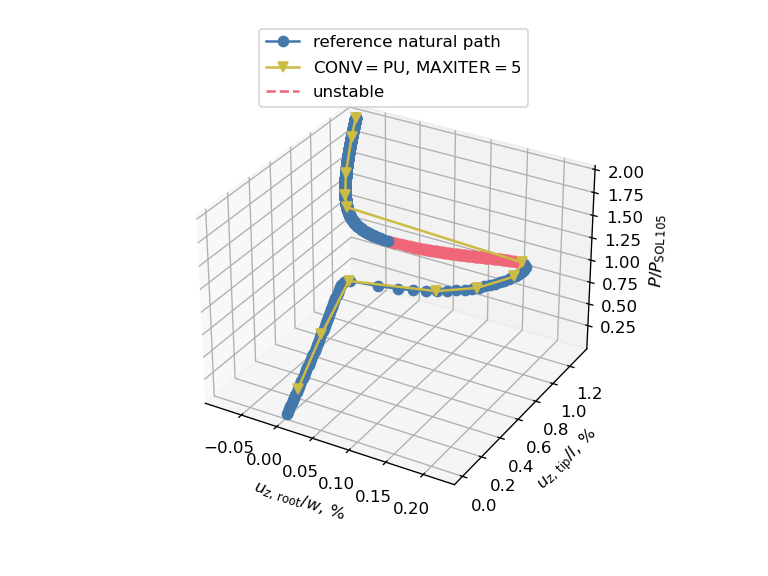

In [11]:
from resources import plot_utils

notebook_18_analysis_directory_path = os.path.join(
    os.getcwd(), "analyses", "18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model")  # path to analysis directory

# Find id of node where linear buckling analysis predicts max displacement
no_elements = len(box_beam_bdf.elements)
sol_105_op2_filepath = os.path.join(notebook_18_analysis_directory_path, f"sol_105_{no_elements}_elements.op2")  # path to SOL 105 OP2 file
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)  # OP2 object of SOL 105 analysis
second_subcase_id = 2  # subcase id of buckling eigenvalue analysis
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
MAX_DISPLACEMENT_NODE_ID = sol_105_op2.eigenvectors[second_subcase_id].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement

# Read eigenvalues and load and displacement history of reference nonlinear analysis
input_name = f"sol_106_{no_elements}_elements_epsu1e-4"
f06_filepath = os.path.join(notebook_18_analysis_directory_path, input_name + '.f06')
REFERENCE_EIGENVALUES = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
op2_filepath = os.path.join(notebook_18_analysis_directory_path, input_name + '.op2')
reference_sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
_, REFERENCE_APPLIED_LOADS, REFERENCE_TIP_DISPLACEMENTS = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=reference_sol_106_op2, displacement_node_id=TIP_MASTER_NODE_ID)
_, _, REFERENCE_ROOT_DISPLACEMENTS = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=reference_sol_106_op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)

# Read load and displacement history of analysis with load and displacement error functions and MAXITER=5
input_name = "sol_106_error_function_pu"
op2_filepath = os.path.join(notebook_18_analysis_directory_path, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=TIP_MASTER_NODE_ID)
_, _, root_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)

# Define function to plot reference natural equilibrium path
def plot_reference_equilibrium_path():
    # Create 3D plot of equilibrium diagram
    plt.figure()
    ax_3d = plt.axes(projection='3d')
    # Plot loads and displacements
    plot_utils.plot_3d_load_displacements_stability(REFERENCE_EIGENVALUES, ax_3d,
                                                    REFERENCE_ROOT_DISPLACEMENTS[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W*100,
                                                    REFERENCE_TIP_DISPLACEMENTS[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L*100,
                                                    REFERENCE_APPLIED_LOADS[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD,
                                                    MARKERS[0], COLORS[0])
    ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, %")
    ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, %")
    ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    ax_3d.grid(visible=True)
    return ax_3d

# Plot reference natural equilibrium path
ax = plot_reference_equilibrium_path()
reference_line = Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="reference natural path")
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Plot equilibrium path of analysis with load and displacement error functions and MAXITER=5
ax.plot3D(root_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W*100,
          tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L*100,
          applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD,
          MARKERS[1] + '-', color=COLORS[1])
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="$\mathrm{CONV}=\mathrm{PU},\,\mathrm{MAXITER}=5$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

As described earlier, we can see that the analysis with load and displacement error functions and $\mathrm{MAXITER}=5$ is not able to capture the unstable part of the equilibrium path.

All the remaining parameters for this analysis are set to their default values, including the desired number of iterations, $I_d$, which is set to $12$. This parameter controls the ratio of the step size between successive iterations:

$$\frac{\Delta l_{new}}{\Delta l_{old}}=\sqrt{\frac{I_d}{I_{max}}},$$

where $I_{max}$ is the number of iterations required to achieve convergence for the last step.

We notice that by choosing $\mathrm{MAXITER}=5$ and $I_d=12$ we are effectively imposing a step size ratio equal or larger than $\sqrt{2.4}$ ($\sqrt{12/5}$). This means that the arc-length solver will not be able to take steps smaller than $\sqrt{2.4}$ times the step size of the last converged step, unless using increment bisection. It then makes sense to set $I_d$ to a value equal to $5$, so that the solver can use step size ratios between $1$ and $\sqrt{5}$, corresponding respectively to $I_{max}=5$ and $1$.

We set up the nonlinear analysis with load and displacement error functions, $\mathrm{MAXITER}=I_d=5$, apply twice the design load, run the analysis, and visualize the results.

Nastran job sol_106_desiter5.bdf completed
Wall time: 429.0 s


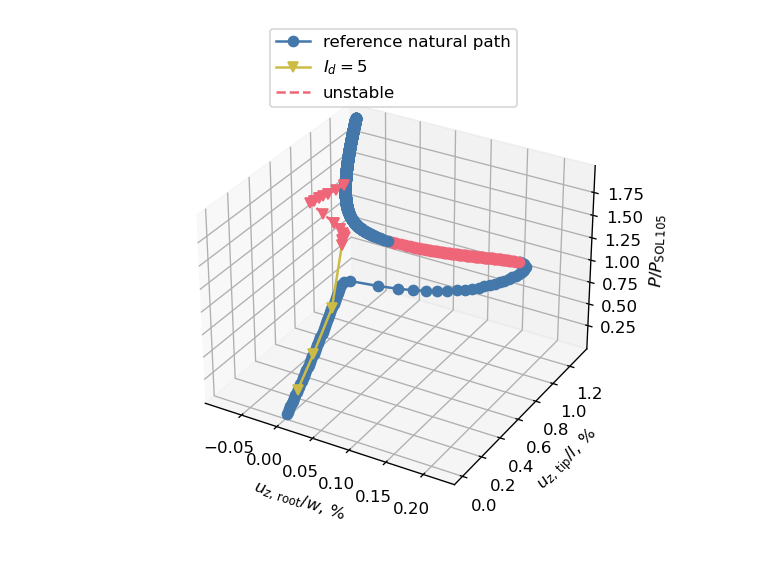

In [12]:
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, conv='PU', max_iter=5, desiter=5)  # set up arc length method
box_beam_bdf.loads[force_set_id][0].mag = DESIGN_LOAD*2  # apply double the design load

# Define function to run analysis and plot equilibrium path
METHOD_SET_ID = force_set_id + 1  # id of method for eigenvalue calculation
NO_EIGENVALUES = 20  # number of tangent stiffness matrix eigenvalues to calculate
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver

def plot_analysis_equilibrium_path(bdf_input, filename, axes, marker, color, run_flag=True):
    # Run analysis
    op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(bdf_object=bdf_input.__deepcopy__({}), method_set_id=METHOD_SET_ID,
                                                             analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=filename,
                                                             no_eigenvalues=NO_EIGENVALUES, upper_eig=UPPER_EIGENVALUE, run_flag=run_flag)
    # Read eigenvalues and load and displacement history from op2 file
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.f06')
    eigs = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    _, loads, tip_disp = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=TIP_MASTER_NODE_ID)
    _, _, root_disp = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
    # Plot load-displacement curve on input axes
    plot_utils.plot_3d_load_displacements_stability(eigs, axes,
                                                    root_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W*100,
                                                    tip_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L*100,
                                                    loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD,
                                                    marker, color)
    
# Run analysis and plot equilibrium path
ax = plot_reference_equilibrium_path()  # plot reference equilibrium path
input_name = "sol_106_desiter5"  # name of input file
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, MARKERS[1], COLORS[1], run_flag=False)  # run new analysis and plot equilibrium path
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="$I_d=5$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

The analysis with $I_d=5$ fails to converge to the prescribed applied load because it reaches the default maximum number of arc-length increments, $20$. At the same time, we observe a jump from the natural path to a complementary path at the fourth increment. We inspect the convergence results of the analysis at this increment in the f06 file.

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         3  3.2328E-03  2.9659E-03  3.7872E-05  1.0000E-01  4.8705E-02  1.0000E+00  7.4023E-02  7.4023E-02    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    1     LOOPID    4     LOAD STEP    0.586     LOAD FACTOR 0.58599681
```

We can see that the increment converges at the third iteration, with a displacement error of $3.2\cdot 10^{-3}$ and a load error of $3.0\cdot 10^{-3}$.

We then lower both convergence tolerances to $10^{-3}$ and we increase the maximum number of increments to $100$. We also lower the minimum allowable arc-length adjustment ratio to $10^{-1}$, as the bisections of the increments in the last analysis resulted in arc-length adjustment ratios in the order of $10^{-1}$.

Nastran job sol_106_epsu1e-3.bdf completed
Wall time: 598.0 s


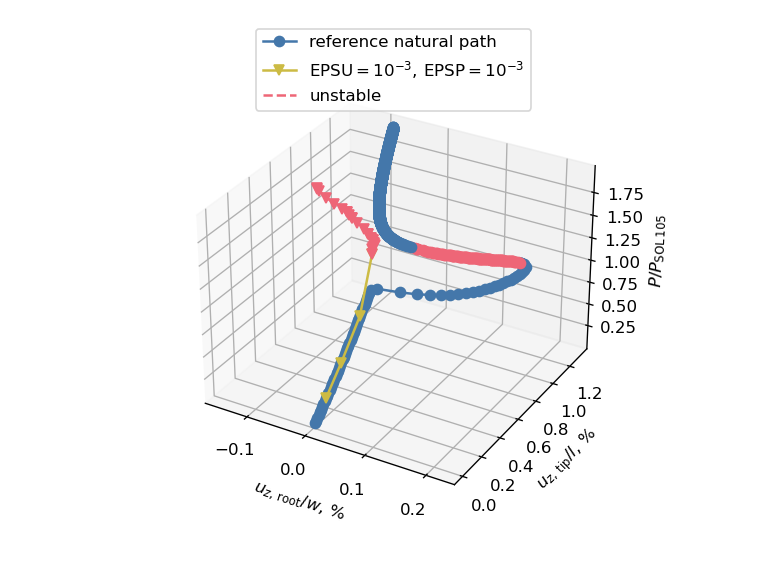

In [13]:
# Change nonlinear analysis parameters
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].eps_u = 1e-3
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].eps_p = 1e-3
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].mxinc = 100
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].minalr = 1e-1

# Run analysis and plot equilibrium path
ax = plot_reference_equilibrium_path()  # plot reference equilibrium path
input_name = "sol_106_epsu1e-3"  # name of input file
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, MARKERS[1], COLORS[1], run_flag=False)  # run new analysis and plot equilibrium path
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="$\mathrm{EPSU}=10^{-3},\,\mathrm{EPSP}=10^{-3}$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

In this case, the analysis fails to converge to the prescribed applied load because it reaches the maximum number of bisections. Also here, we observe a jump from the natural path to a complementary path at the fourth increment. Once again we inspect the convergence results of the analysis at this increment in the f06 file.

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         4  1.6871E-04  3.1931E-05  7.3704E-09  1.0000E-01  2.0420E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    1     LOOPID    4     LOAD STEP    0.611     LOAD FACTOR 0.61064795
```

The increment converges at the fourth iteration, with a displacement error of $1.7\cdot 10^{-4}$ and a load error of $3.2\cdot 10^{-5}$.

We modify again the nonlinear analysis parameters, setting the displacement tolerance to $10^{-4}$, the load tolerance to $10^{-5}$, the maximum number of bisections to $20$ and the maximum number of iterations and the desired number of iterations to $4$. We run the analysis and visualize the results.

Nastran job sol_106_epsu1e-4.bdf completed
Wall time: 1566.0 s


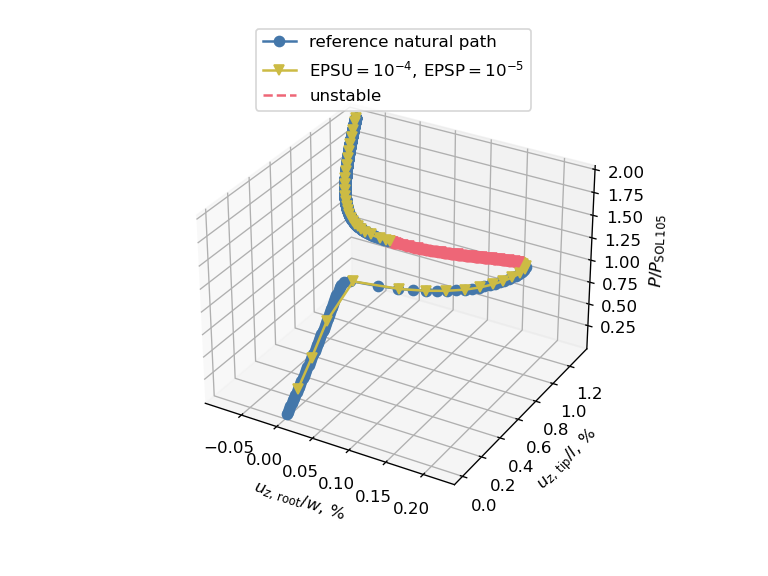

In [14]:
# Change nonlinear analysis parameters
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].eps_u = 1e-4
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].eps_p = 1e-5
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].max_bisect = 20
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].max_iter = 4
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].desiter = 4

# Run analysis and plot equilibrium path
ax = plot_reference_equilibrium_path()  # plot reference equilibrium path
input_name = "sol_106_epsu1e-4"  # name of input file
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, MARKERS[1], COLORS[1], run_flag=False)  # run new analysis and plot equilibrium path
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="$\mathrm{EPSU}=10^{-4},\,\mathrm{EPSP}=10^{-5}$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

Eureka! We've succeded in converging to the perscribed applied load and in capturing the unstable part of the natural equilibrium path. We can observe that the selected nonlinear analyses parameters have allowed the arc-length solver to take relatively large increments at the beginning of the analysis and to refine them as the structure approaches the load limit point and the unstable part of the equilibrium path. In this way we have achieved a good compromise between computational efficiency and robustness, employing approximately 25 minutes to run the nonlinear analysis.

Can we find a way to further reduce the computational time? A possible solution is to consider an alternative approach to our current full Newton iteration method, where the tangent stiffness matrix is updated at every iteration. A popular alternative is the so-called modified Newton iteration method, where the tangent stiffness matrix is updated only at the beginning of the increment and then kept constant. This approach is less computationally expensive than the full Newton iteration method, but it is also less robust, because the solver does not use the true Jacobian of the system. The implication is that convergence can be slowed down and in extreme cases it can be prevented at all. Consequently, we need to test the modified Newton iteration method with the current nonlinear analysis parameters to verify whether it can provide a computational time reduction without compromising the robustness of the analysis.

The closest implementation of the modified Newton iteration method in Nastran can be obtained using $\mathrm{KSTEP}=\mathrm{AUTO}$. With this option, the solver automatically selects whether to update the stiffness matrix at each iteration or use the old matrix based on convergence rates. In practice, this means that the solver always tries not to update the stiffness matrix, unless it estimates that the number of iterations to converge exceeds $\mathrm{MAXITER}$ or that the time required for convergence with current stiffness exceeds the estimated time required for convergence with updated stiffness. The tangent stiffness matrix is always updated when the increment converges, so that it can be used for the next increment.

We set $\mathrm{KSTEP}$ to $\mathrm{AUTO}$ and we also increase the maximum number of increments to 200 and decrease the minimum allowable arc-length adjustment ratio to $10^{-5}$, as the bisections of the increments in the last analysis resulted in arc-length adjustment ratios in the order of $10^{-5}$. 

Nastran job sol_106_epsu1e-4_auto.bdf completed
Wall time: 2114.0 s


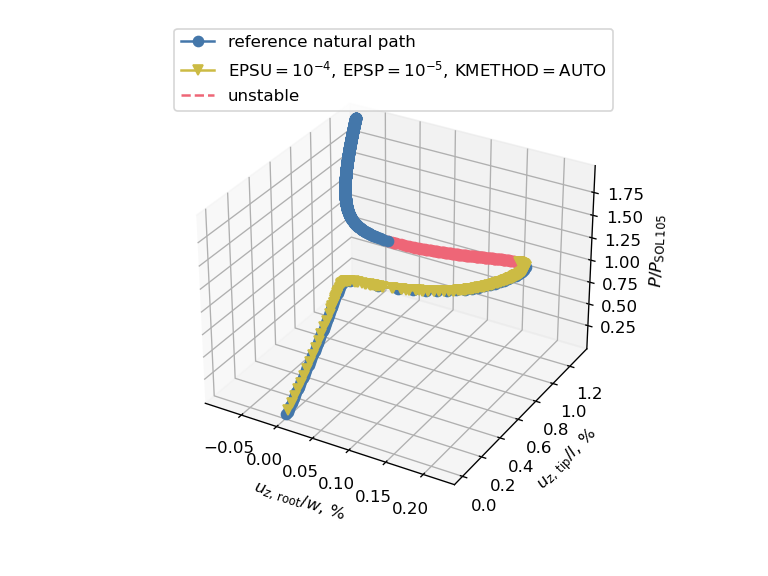

In [15]:
# Change nonlinear analysis parameters
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].kmethod = 'AUTO'
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].mxinc = 200
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].minalr = 1e-5

# Run analysis and plot equilibrium path
ax = plot_reference_equilibrium_path()  # plot reference equilibrium path
input_name = "sol_106_epsu1e-4_auto"  # name of input file
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, MARKERS[1], COLORS[1], run_flag=False)  # run new analysis and plot equilibrium path
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1],
                       label="$\mathrm{EPSU}=10^{-4},\,\mathrm{EPSP}=10^{-5},\,\mathrm{KMETHOD}=\mathrm{AUTO}$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

The analysis fails to converge to the prescribed load because it reached the maximum number of bisections. Looking at the load-displacement diagram, we can see that the analysis stops a few increments after reaching the load limit point. Inspecting the f06 file, after the last converged increment we find several instances of no root case being encountered:

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         1  2.3212E-04  3.2444E-05  3.1665E-10  1.0000E-01  8.1316E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6192 (NLROOT)
     *** NO ROOT CASE HAS BEEN ENCOUNTERED ***
 *** USER INFORMATION MESSAGE 6187 (NLITER)
     *** BISECTION METHOD IS NOW ACTIVATED ***
 *** USER INFORMATION MESSAGE 6188 (NLITER)
     ***  ARC LENGTH RATIO IS 6.103516D-06
         1  1.1606E-04  2.0971E-05  1.2499E-10  1.0000E-01  7.1734E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6192 (NLROOT)
     *** NO ROOT CASE HAS BEEN ENCOUNTERED ***
 *** USER INFORMATION MESSAGE 6187 (NLITER)
     *** BISECTION METHOD IS NOW ACTIVATED ***
 *** USER INFORMATION MESSAGE 6188 (NLITER)
     ***  ARC LENGTH RATIO IS 3.051758D-06
         1  5.8029E-05  1.5320E-05  5.4208E-11  1.0000E-01  6.6947E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6192 (NLROOT)
     *** NO ROOT CASE HAS BEEN ENCOUNTERED ***
 *** USER INFORMATION MESSAGE 6187 (NLITER)
     *** BISECTION METHOD IS NOW ACTIVATED ***
 *** USER INFORMATION MESSAGE 6188 (NLITER)
     ***  ARC LENGTH RATIO IS 1.525879D-06
         1  2.9014E-05  1.2531E-05  2.5045E-11  1.0000E-01  6.4554E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6192 (NLROOT)
     *** NO ROOT CASE HAS BEEN ENCOUNTERED ***
 *** USER INFORMATION MESSAGE 6187 (NLITER)
     *** BISECTION METHOD IS NOW ACTIVATED ***
 *** USER INFORMATION MESSAGE 6188 (NLITER)
     ***  ARC LENGTH RATIO IS 7.629395D-07
         1  1.4507E-05  1.1155E-05  1.2011E-11  1.0000E-01  6.3358E-04  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6192 (NLROOT)
     *** NO ROOT CASE HAS BEEN ENCOUNTERED ***
 *** USER INFORMATION MESSAGE 6193 (NLITER)
     *** MAXIMUM NUMBER OF BISECTIONS OR MINIMUM ARC LENGTH HAS BEEN REACHED.
 ^^^     
 *** USER INFORMATION MESSAGE 9052 (SUBDMAP NLSTATIC)
     NONLINEAR STATIC ANALYSIS COMPLETED.
```

This results suggest that the arc-length solver is struggling to find solutions on the unstable part of the equilibrium path without updating the stiffness matrix.

To solve this issue, we can try to set $\mathrm{KMETHOD}$ to $\mathrm{SEMI}$. With this option, the solver carries out the first iteration of the new increment, updates the stiffness matrix, and resumes with $\mathrm{KMETHOD}=\mathrm{AUTO}$. By always updating the stiffness matrix after the first increment, we expect the robustness of the solver to increase. Let's test this on our case.

Nastran job sol_106_epsu1e-4_semi.bdf completed
Wall time: 1740.0 s


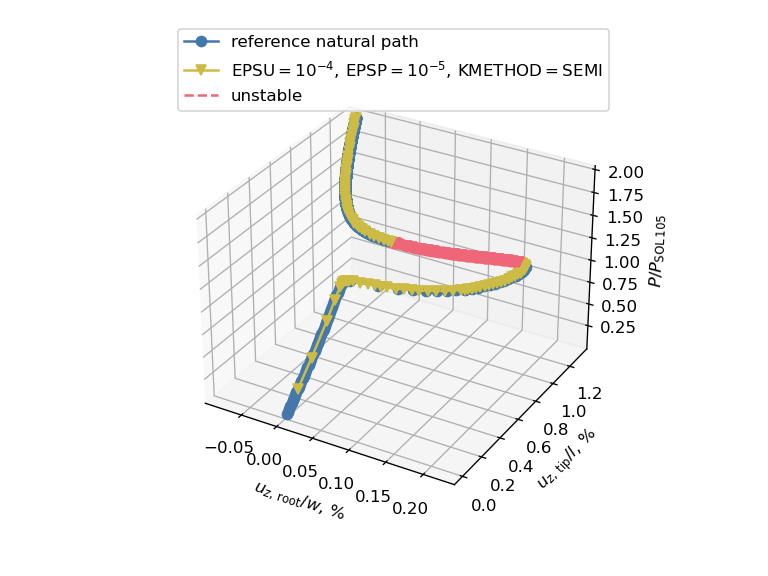

In [16]:
# Change nonlinear analysis parameters
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].kmethod = 'SEMI'

# Run analysis and plot equilibrium path
ax = plot_reference_equilibrium_path()  # plot reference equilibrium path
input_name = "sol_106_epsu1e-4_semi"  # name of input file
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, MARKERS[1], COLORS[1], run_flag=False)  # run new analysis and plot equilibrium path
analysis_line = Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1],
                       label="$\mathrm{EPSU}=10^{-4},\,\mathrm{EPSP}=10^{-5},\,\mathrm{KMETHOD}=\mathrm{SEMI}$")

# Show plot
ax.legend(handles=[reference_line, analysis_line, unstable_line], loc="upper center", bbox_to_anchor=(0.5, 1.11))
plt.show()

Great, the analysis has successfully converged to the prescribed load! However, looking at the computational time, it seems that we did not achieve in our goal of reducing it. In fact our last analysis took about 80 seconds longer than the analysis with the full Newton method. Consequently, we choose to use the latter to run the optimization.

To assess the accuracy of the analysis with the efficient set of parameters, we calculate the percentage difference of the applied load at the first limit point with respect to the reference analysis with very fine arc-length increments.

In [17]:
# Read eigenvalues and load and displacement history from op2 file
input_name = "sol_106_epsu1e-4"
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
eigenvalues_dict = {"reference": REFERENCE_EIGENVALUES,
                   "epsu1e-4": eigenvalues}
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2 = read_op2(op2_filepath, debug=None)
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)
applied_loads_dict = {"reference": REFERENCE_APPLIED_LOADS,
                      "epsu1e-4": applied_loads}

# Find applied load at limit point
first_negative_eigenvalue_index = {}  # dictionary to store index of first negative eigenvalue
limit_point_nondimensional_applied_load = {}  # dictionary to store nondimensional applied load at limit point
for key in eigenvalues_dict:
    first_negative_eigenvalue_index[key] = np.where(eigenvalues_dict[key][0, :] < 0)[0][0]  # find index of first negative eigenvalue
    limit_point_nondimensional_applied_load[key] = np.mean(applied_loads_dict[key][FIRST_SUBCASE_ID][
        first_negative_eigenvalue_index[key] - 1:first_negative_eigenvalue_index[key] + 1, Z_COMPONENT_INDEX])/DESIGN_LOAD  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load

# Print applied loads and percentage difference
print(f"""
Nondimensional applied load at first limit point:
- reference analysis: {limit_point_nondimensional_applied_load["reference"]:.2f}
- efficient parameters analysis: {limit_point_nondimensional_applied_load["epsu1e-4"]:.2f}
Percentage difference of efficient parameters analysis w.r.t. reference: {
    (limit_point_nondimensional_applied_load["epsu1e-4"]/limit_point_nondimensional_applied_load["reference"] - 1)*100:.3f} %""")


Nondimensional applied load at first limit point:
- reference analysis: 1.42
- efficient parameters analysis: 1.42
Percentage difference of efficient parameters analysis w.r.t. reference: 0.001 %


The negligible percentage difference confirms that by choosing the more efficient set of parameters accuracy is not lost with respect to the reference analysis.

Before moving on to the optimization, is there anything else that we can do to reduce the computational time of the nonlinear analyses? Yes there is! We can use the parallel computing capabilities of SOL 106. Since it is quite an old solution sequence, SOL 106 does not have great parallel computing capabilities, but it can still parallelize matrix decomposition and multiplication. Better than nothing!

To use the parallel computing capabilities of SOL 106 we need to specify `NASTRAN PARALLEL=N` in the system command section of the input file, where `N` is the number of cores. How many cores should we use? Well, of course it depends on the machine that we have! On my machine I have 12 logical processors, meaning that we can use up to 12 cores. To test what number of cores gives the smallest computational time, we run the analysis with 2, 4, 8 and 12 cores, and look at the final computational times.

In [18]:
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].kmethod = 'ITER'  # restore full Newton method
no_cores = [2, 4, 8, 12]  # define list of number of cores to try
box_beam_bdf.system_command_lines.append("")  # add empty line to system command lines
for cores in no_cores:
    box_beam_bdf.system_command_lines[0] = f"NASTRAN PARALLEL={cores:d}"  # add command to run Nastran in parallel
    input_name = f"sol_106_epsu1e-4_{cores}cores"  # name of input file
    pynastran_utils.run_sol_106_with_kllrh_eigenvalues(bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID,
                                                       analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
                                                       no_eigenvalues=NO_EIGENVALUES, upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job sol_106_epsu1e-4_2cores.bdf completed
Wall time: 1458.0 s
Nastran job sol_106_epsu1e-4_4cores.bdf completed
Wall time: 1425.0 s
Nastran job sol_106_epsu1e-4_8cores.bdf completed
Wall time: 1595.0 s
Nastran job sol_106_epsu1e-4_12cores.bdf completed
Wall time: 1635.0 s


The analysis with 4 cores is the one that results in the lowest computational time, so we add `NASTRAN PARALLEL=4` to the system command section.

In [19]:
box_beam_bdf.system_command_lines[0] = "NASTRAN PARALLEL=4"

## Optimization <a name="optimization"></a>

***

We are finally ready to set up and run our first optimization. We start by restoring the mangnitude of the applied load to that of the design load and by reducing the maximum number of increments to 100, as the analysis employing the efficient set of parameters employed 63 iterations to converge.

In [20]:
box_beam_bdf.loads[force_set_id][0].mag = DESIGN_LOAD
box_beam_bdf.nlpcis[FIRST_SUBCASE_ID].mxinc = 100

Then we set up the nonlinear analysis to calculate the 20 smallest eigenvalues of the tangent stiffness matrix for every converged increment, by calling the function `set_up_sol_106_with_kllrh_eigenvalues`. This function does the same set up work of `run_sol_106_with_kllrh_eigenvalues` but it does not run the analysis. To further reduce the computational time of the optimization, this time we add the option `dmap_option='stop'`. This option includes in the bdf file a different version of the DMAP for the calculation of the eigenvalues of the tangent stiffness matrix, which stops the analysis when the first negative eigenvalue is found. In this way we can avoid running the analysis for increments that are beyond the loss of stability, since these have no interest for the optimization.

In [21]:
box_beam_bdf_opt = box_beam_bdf.__deepcopy__({})
pynastran_utils.set_up_sol_106_with_kllrh_eigenvalues(bdf_object=box_beam_bdf_opt, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                      method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES, upper_eig=UPPER_EIGENVALUE,
                                                      dmap_option='stop')

To run our optimization with OpenMDAO we need to define an instance of the `Problem` class. This class constitutes the top-level container for the model hierarchy, and it is used to set up the optimization problem. Let's create an instance of this class using the previously defined `NastranSolverGroup` as the `model` argument. We then call the `setup` method to get the data structures of the framework in place.

In [22]:
input_name = "sol_106_optimization"  # default name for input file
nastran_group = NastranSolverGroup(bdf_object=box_beam_bdf_opt, input_name=input_name, run_flag=False)  # create NastranGroup object
nonlinear_problem = om.Problem(model=nastran_group, name=input_name)
nonlinear_problem.setup()

A good practice in optimization is to normalize objective, design variables and constraints with respect to some reference values. A very popular choice for this normalization is to use the values corresponding to the initial design. For this reason, we assign the initial value of wall thickness to the design variable, run our `Problem` object with the method `run_model`, and record the values of the objective and constraint functions.

In [23]:
# Run model with initial design variable
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name + "_start"  # change input name for analysis of initial structure
nonlinear_problem.set_val('nastran_solver.t', t0)
nonlinear_problem.run_model()

# Record initial objective and constraint function values
mass_0 = nonlinear_problem['nastran_solver.mass'][0]
ks_stability_0 = nonlinear_problem["nastran_solver.ks_stability"][0]
ks_stress_0 = nonlinear_problem["nastran_solver.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial KS value for stability: {ks_stability_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job sol_106_optimization_start.bdf completed
Wall time: 89.0 s
Initial mass: 6519 kg
Initial KS value for stability: -20.7 N/m
Initial KS value for stress: -399 MPa


Now we set up the optimization problem in the follwowing steps:
- define the default input values of the `NastranSolver` component;
- select COBYLA as the optimization algorithm;
- define the design variable, objective and constraints functions together with their bounds and scaling factors.

For the wall thickness we select an bounding interval between 1 and 20 mm.

In [24]:
# Set default input values of nastran_solver component
nonlinear_problem.model.set_input_defaults('nastran_solver.t', t0)  # initial thickness
nonlinear_problem.model.options['input_name'] = input_name  # restore default input name for analyses during optimization

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
nonlinear_problem.model.add_design_var('nastran_solver.t', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
nonlinear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stability', upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.applied_load', lower=DESIGN_LOAD*.99, ref=DESIGN_LOAD)  # scale applied load so that design

Before running the optimization, we are going to create a recorder and attach it to our `Problem` object. This will allow us to save the values of the design variable, objective and constraints at each iteration of the optimization.

In [25]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

Finally, we can run the optimization calling the method `run_driver` of our `Problem` object.

In [26]:
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # shut down all recorders and clean up driver and model resources

Let's plot the convergence history of the optimization. To do this, we define the function `plot_optimization_history`, that takes as input the path to the recorder file, plots the convergence history of the design variable, constraints and objective, and returns a dictionary with their histories.

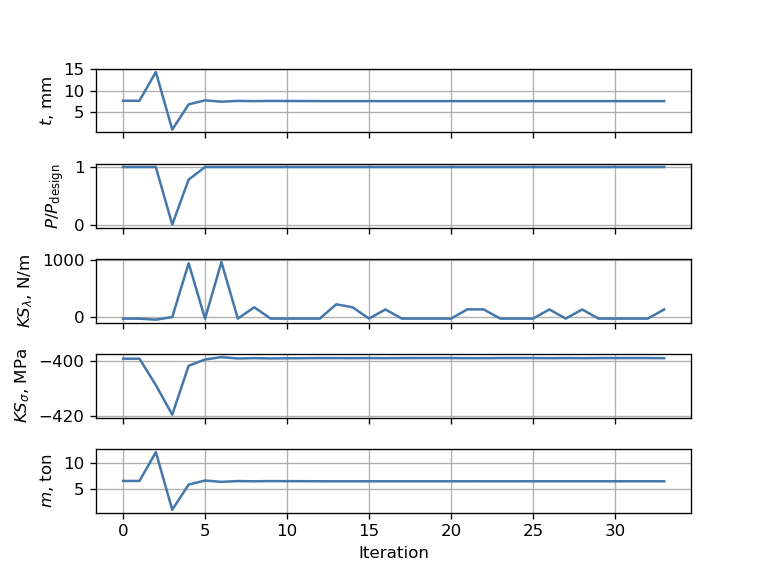

In [27]:
def plot_optimization_history(recorder_filepath):
    # Initialize the CaseReader object
    cr = om.CaseReader(recorder_filepath)
    # Extract driver cases without recursing into system or solver cases
    driver_cases = cr.get_cases('driver', recurse=False)
    # Prepare data structures for plotting
    output_keys = list(driver_cases[0].outputs.keys())
    no_outputs = len(output_keys)
    histories = {key: np.array([case[key] for case in driver_cases]) for key in output_keys}  # retrieve histories of the functions
    # Setup plot labels
    y_labels = ["$t$, mm", "$P/P_\mathrm{design}$", "$KS_{\lambda}$, N/m", "$KS_{\sigma}$, MPa","$m$, ton"]
    # Normalize applied load history
    histories['nastran_solver.applied_load'] = histories['nastran_solver.applied_load']/histories['nastran_solver.applied_load'][0]
    # Create figure and axes for subplots
    fig, axes = plt.subplots(no_outputs, 1, sharex=True)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    # Plot each history
    iterations_array = np.arange(len(next(iter(histories.values()))))
    for i, key in enumerate(histories):
        axes[i].plot(iterations_array, histories[key])
        axes[i].set(ylabel=y_labels[i])
        axes[i].grid()
    axes[-1].set(xlabel="Iteration")
    # Show plot and return histories
    plt.show()
    return histories

sol_106_opt_histories = plot_optimization_history(recorder_filepath)

The optimization history shows that the last design point is actually unfeasible, as $KS_\lambda$ has a positive value. We consider the last feasible design point and find the final value of wall thickness and of the constraints. We also calculate the percentage mass reduction with respect to the initial structure.

In [28]:
# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_percentage_variation = (sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
print(f"""Final thickness: {sol_106_opt_histories['nastran_solver.t'][feasible_design_index, 0]:.1f} mm
Final KS value of nonlinear structural stability: {sol_106_opt_histories['nastran_solver.ks_stability'][feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {sol_106_opt_histories['nastran_solver.ks_stress'][feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {sol_106_opt_histories['nastran_solver.applied_load'][feasible_design_index, 0]:.2f}
Mass variation: {mass_percentage_variation:.1f} %""")

Final thickness: 7.6 mm
Final KS value of nonlinear structural stability: -19.96 N/m
Final KS value for stress: -399 MPa
Final nondimensional applied load: 1.00
Mass variation: -1.0 %


From the above results, it seems that the optimizer managed to reduce the wall thickness only slighlty, obtaining a meager 1% mass reduction. The margin of stability is also reduced only slightly with respect to that of the initial structure, suggesting that the structure has still much margin for mass reduction. What is happening?

Let's plot the eigenvalue and the load-displacement diagram of the structure at the last point of the optimization, the unfeasible one, to inspect the response obtained from the nonlinear analysis.

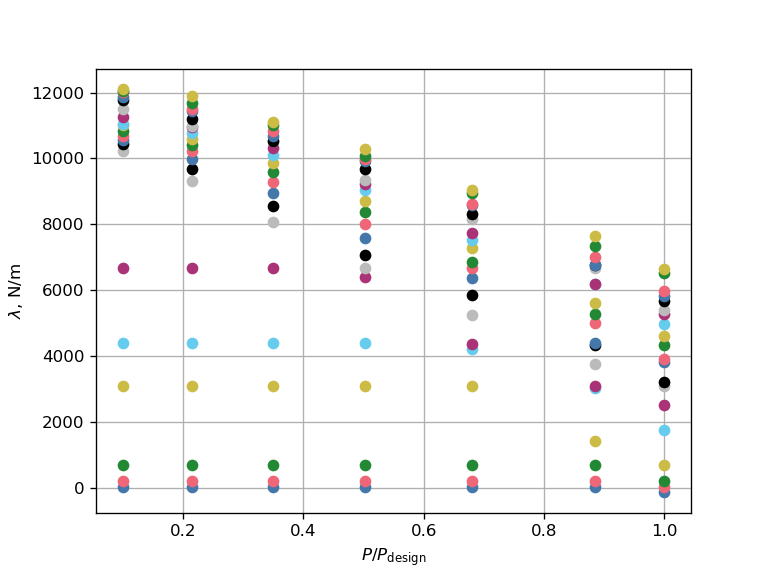

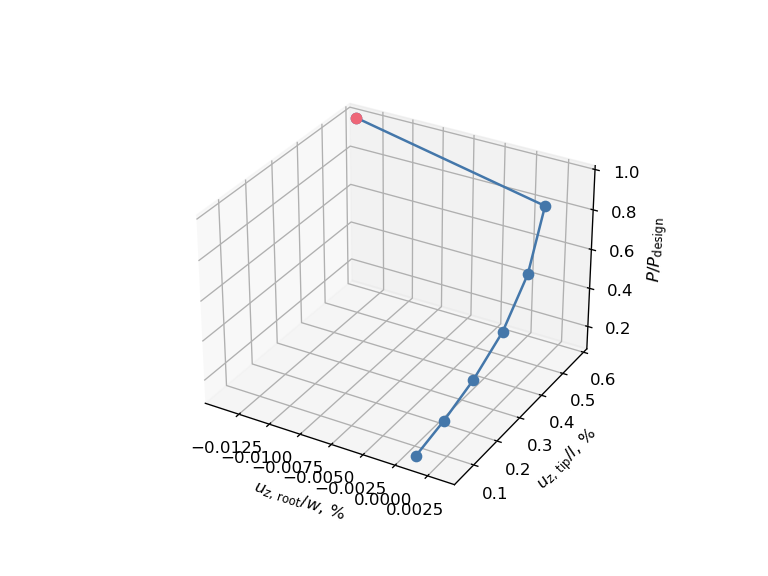

In [29]:
def plot_eigenvalues_and_load_displacement_diagrams(filename, op2):
    # Read eigenvalues of tangent stiffness matrix
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.f06')  # path to .f06 file
    eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Read load and displacement history
    _, applied_loads, root_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
    _, _, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=TIP_MASTER_NODE_ID)
    # Nondimensionalize loads and displacements
    nondimensional_loads = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
    nondimensional_displacements = {"root": root_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}
    # Plot eigenvalues vs applied load
    _, ax = plt.subplots()
    ax.plot(nondimensional_loads, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    ax.set_ylabel("$\lambda$, N/m")
    ax.set_xlabel("$P/P_\mathrm{design}$")
    ax.grid(visible=True)
    plt.show()
    # Plot load-displacement diagram
    plt.figure()
    ax_3d = plt.axes(projection='3d')
    plot_utils.plot_3d_load_displacements_stability(eigenvalues, ax_3d,
                                                    nondimensional_displacements["root"]*100,
                                                    nondimensional_displacements["tip"]*100,
                                                    nondimensional_loads, MARKERS[0], COLORS[0])
    ax_3d.set_xlabel("$u_{{z,\,\mathrm{root}}}/w$, %")  # set x-axis label
    ax_3d.set_ylabel("$u_{{z,\,\mathrm{tip}}}/l$, %")  # set y-axis label
    ax_3d.set_zlabel("$P/P_\mathrm{design}$")
    ax_3d.grid(visible=True)  # show grid
    plt.show()

# Read op2 file of optimization result and plot diagrams
sol_106_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + ".op2"), load_geometry=True, debug=None)
plot_eigenvalues_and_load_displacement_diagrams(input_name, sol_106_op2)

The load-displacement diagram shows that the final unstable equilibrium point is characterized by a larger root displacement magnitude compared to the other equilibrium points, but with a negative value. This is in contrast with the results of the initial structure, where there is indeed an increase in the root displacement corresponding to the broken supercritical pitchfork, but the displacement remains positive. This suggests that the arc-length solver might have accidentally jumped on a complementary path. We then inspect the convergence of the last increment in the f06 file.

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         4  9.9904E-05  3.1832E-06  1.1991E-09  1.0000E-01  4.8751E-05  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    1     LOOPID    7     LOAD STEP    1.000     LOAD FACTOR 1.00000000
```

The increment converges at the fourth iteration, with a displacement error of $9.9\cdot 10^{-5}$ and a load error of $3.2\cdot 10^{-6}$. To verify whether the solver has jumped to a complementary path we can repeat the analysis using tighter set of parameters to enforce convergence. Looking at the convergence results of the last increment, we can do this in two way:

- reduce $\mathrm{MAXITER}$ from 4 to 3 keeping the same convergence tolerances;
- or reduce the convergence tolerances to $\mathrm{EPSU}=10^{-5}$ and $\mathrm{EPSP}=10^{-6}$ keeping $\mathrm{MAXITER}=4$.

Let's try with the second option, with the aim of keeping $\mathrm{MAXITER}=4$ and providing the solver with more room to increase the increment where the equilibrium path is not extremely nonlinear. We run the analysis and we plot the eigenvalue and the load-displacement diagrams.

Nastran job sol_106_optimization_epsu1e-5.bdf completed
Wall time: 231.0 s


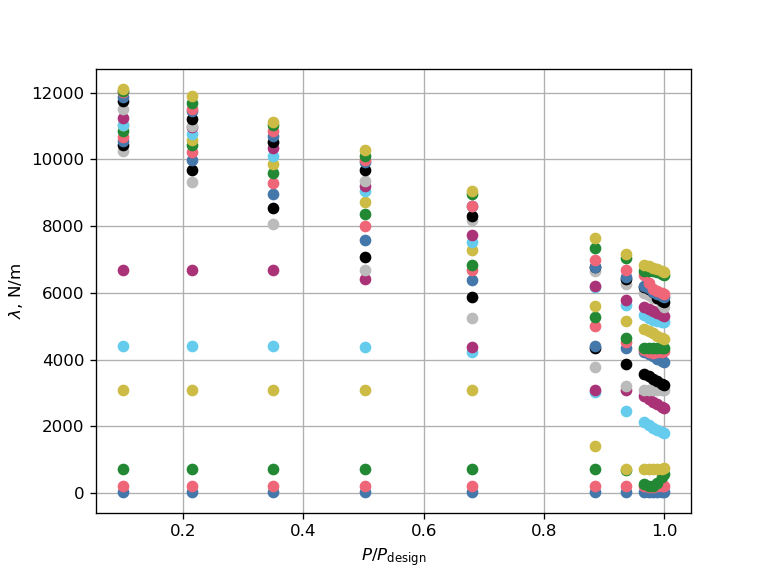

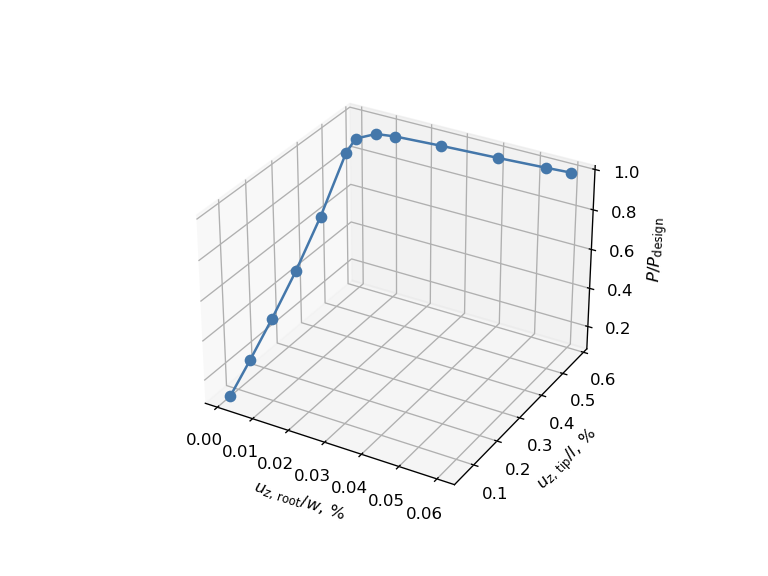

In [30]:
# Modify input
input_name = "sol_106_optimization_epsu1e-5"
nonlinear_problem.model.options['input_name'] = input_name
nonlinear_problem.model.options['bdf_object'].nlparms[FIRST_SUBCASE_ID].eps_u = 1e-5
nonlinear_problem.model.options['bdf_object'].nlparms[FIRST_SUBCASE_ID].eps_p = 1e-6

# Run analysis
nonlinear_problem.setup()
nonlinear_problem.set_val('nastran_solver.t', sol_106_opt_histories["nastran_solver.t"][-1, 0])
nonlinear_problem.run_model()

# Retrieve op2 object and plot diagrams
sol_106_op2 = nonlinear_problem['nastran_solver.op2']
plot_eigenvalues_and_load_displacement_diagrams(input_name, sol_106_op2)

The above results suggest indeed that in the previous analysis the solver jumped to a complementary path because the convergence tolerances were too loose for the analyzed case. In fact, in the last analysis, the solver reduced the arc-length increments drastically as the applied load approached to $P/P_\text{desgin}=1$.

Let's repeat the optimization with these values of convergence tolerances.

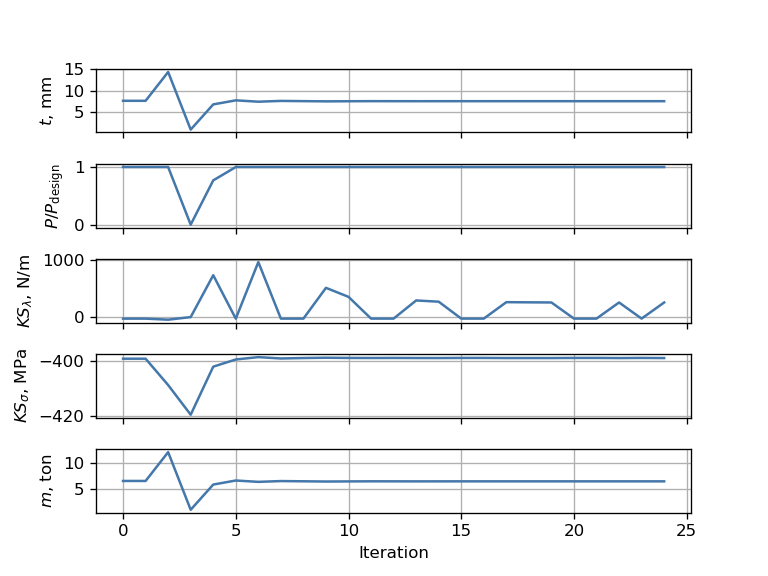

In [31]:
# Set default input values of sol_106 component
input_name = "sol_106_optimization2"
nonlinear_problem.model.options['input_name'] = input_name

# Add recorder
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

# Plot optimization history
sol_106_opt_histories = plot_optimization_history(recorder_filepath)

Once again, the optimization ends on an unfeasible point, so we look at the design variable, constraints and objective of the last feasible point.

In [32]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_percentage_variation = (sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
print(f"""Final thickness: {sol_106_opt_histories['nastran_solver.t'][feasible_design_index, 0]:.1f} mm
Final KS value of nonlinear structural stability: {sol_106_opt_histories['nastran_solver.ks_stability'][feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {sol_106_opt_histories['nastran_solver.ks_stress'][feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {sol_106_opt_histories['nastran_solver.applied_load'][feasible_design_index, 0]:.2f}
Mass variation: {mass_percentage_variation:.1f} %""")

Final thickness: 7.6 mm
Final KS value of nonlinear structural stability: -19.91 N/m
Final KS value for stress: -399 MPa
Final nondimensional applied load: 1.00
Mass variation: -1.2 %


The results show an analogous situation to what we found after the first optimization. We then plot the eigenvalue and load-displacement diagrams to check whether the arc-length solver has jumped to a complementary path in the last analysis.

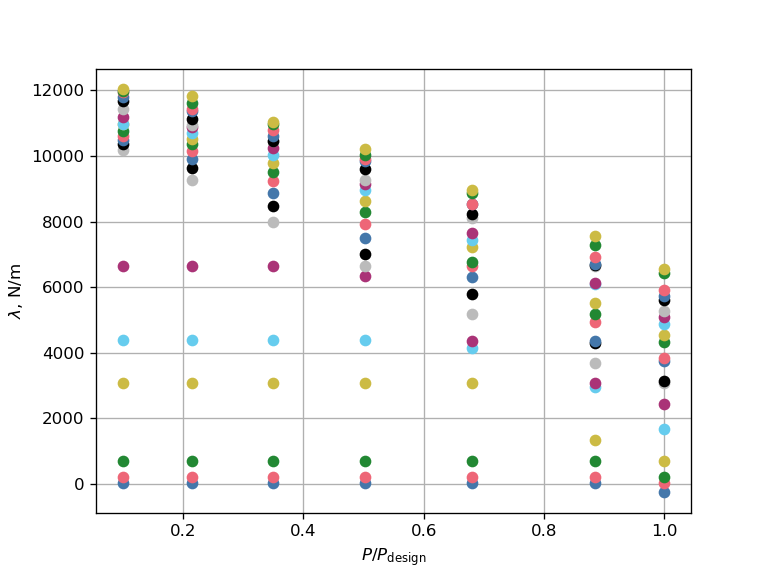

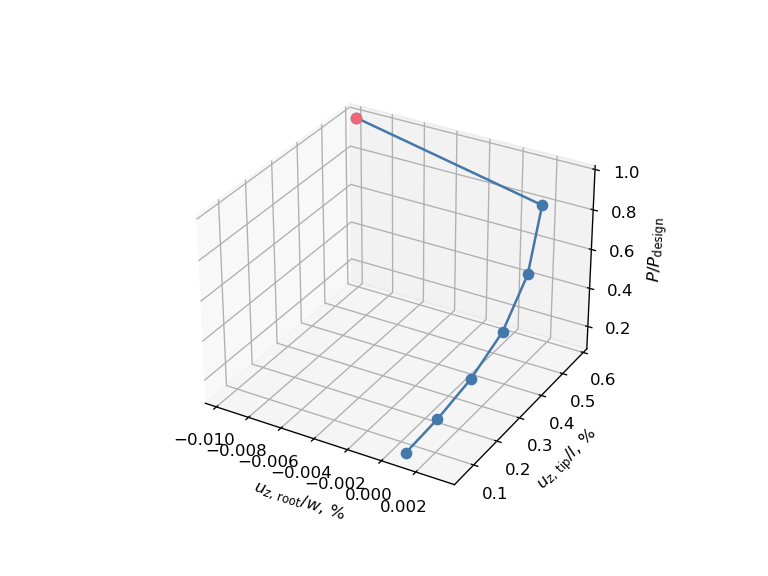

In [33]:
sol_106_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
plot_eigenvalues_and_load_displacement_diagrams(input_name, sol_106_op2)

The above results are totally analogous to what we found earlier, confirming that also in this case, despite the use of tighter convergence tolerances, the solver jumped to a complementary path because the convergence tolerances were still too loose.

Consequently, we have to consider the other option mentioned earlier, that is to say lowering $\mathrm{MAXITER}$ from 4 to 3. However, what value of desired number of iterations should we use? If we lower also $I_d$ to 3, then the arc-length solver will have very small room to increase the arc-length increments, as the only case when this will happen is when the increment converges in 2 iterations. This can cause the arc-length increments to remain small during the analsis, entailing an increase in the computational time. At the same time, if we keep $I_d=4$ to give more room to the solver to take larger increments, the increments will always be increased. This can entail an excessive increase of the increments and cause the solver to take more bisections.

To make an inoformed choice between $I_d=3$ and $4$, we run two different analyses on the initial structure. We apply twice the design load and stop the analysis at the first negative eigenvalue, to deal with a representative case of the optimization. For each analysis we look at the computational time and we plot the eigenvalue and the load-displacement diagrams.

Nastran job sol_106_maxiter3_desiter3.bdf completed
Wall time: 1031.0 s


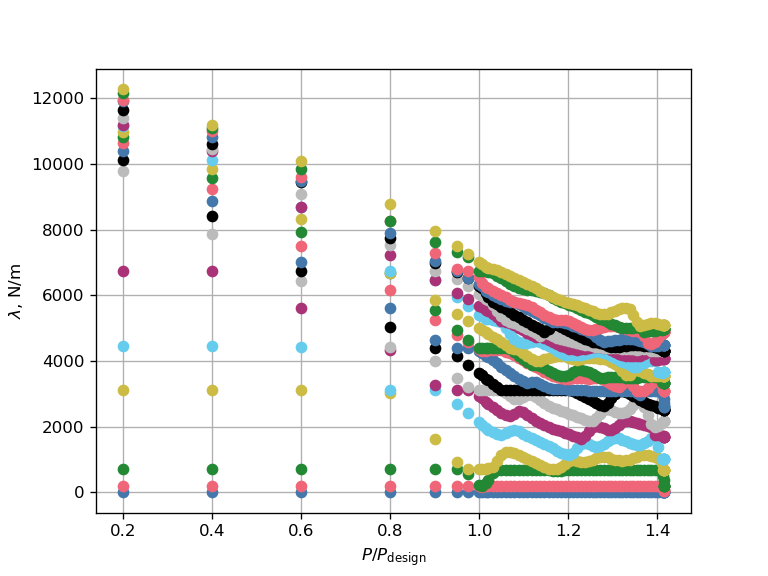

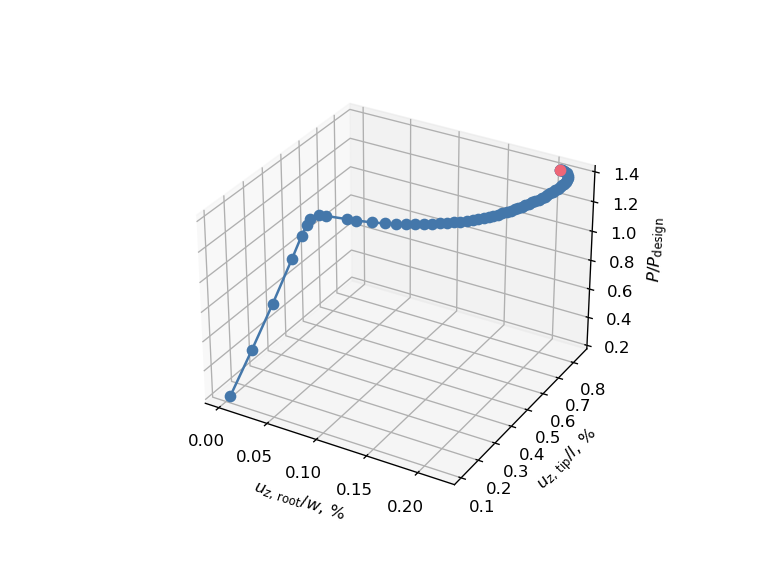

Nastran job sol_106_maxiter3_desiter4.bdf completed
Wall time: 712.0 s


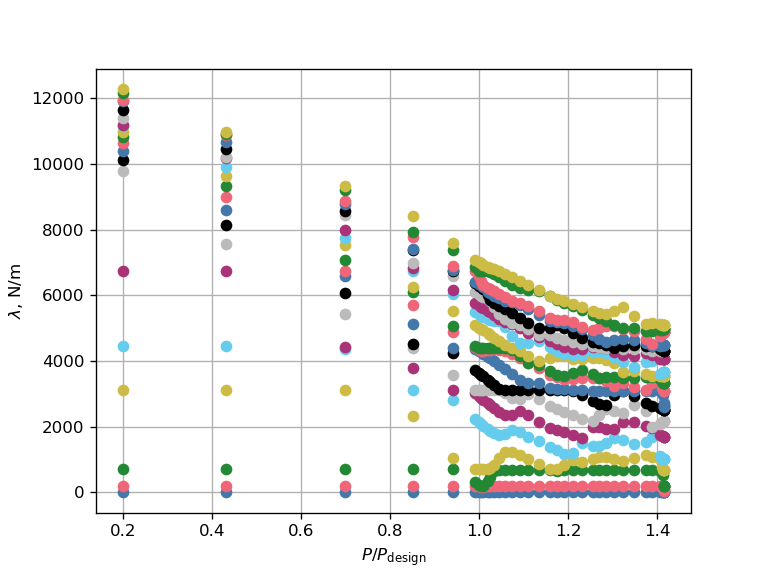

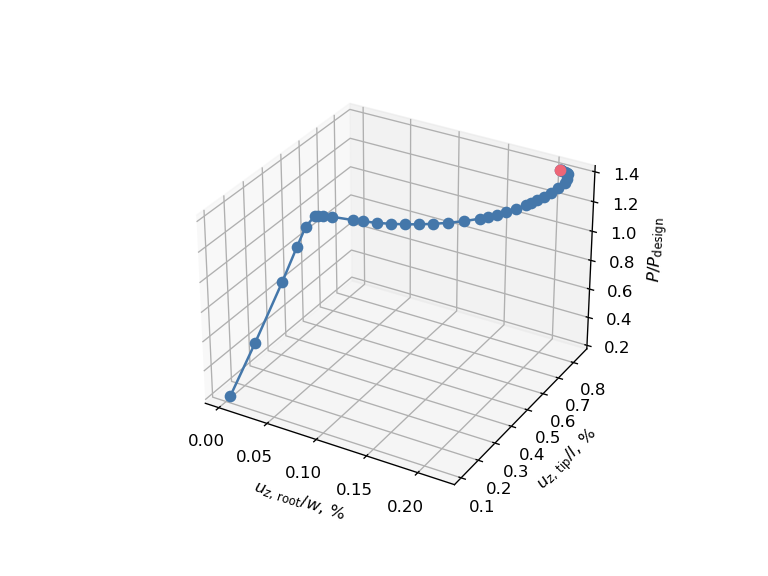

In [34]:
# Set MAXITER=3 and restore old convergence tolerances
nonlinear_problem.model.options['bdf_object'].nlparms[FIRST_SUBCASE_ID].max_iter = 3
nonlinear_problem.model.options['bdf_object'].nlparms[FIRST_SUBCASE_ID].eps_u = 1e-4
nonlinear_problem.model.options['bdf_object'].nlparms[FIRST_SUBCASE_ID].eps_p = 1e-5
nonlinear_problem.model.options['bdf_object'].loads[force_set_id][0].mag = DESIGN_LOAD*2  # apply twice the design load

# Iterate through the values of desired number of iterations
desired_no_iterations = [3, 4]
for desiter in desired_no_iterations:
    # Modify input
    input_name = f"sol_106_maxiter3_desiter{desiter}"
    nonlinear_problem.model.options['input_name'] = input_name
    nonlinear_problem.model.options['bdf_object'].nlpcis[FIRST_SUBCASE_ID].desiter = desiter
    # Run analysis
    nonlinear_problem.setup()
    nonlinear_problem.set_val('nastran_solver.t', t0)
    nonlinear_problem.run_model()
    # Retrieve op2 object and plot diagrams
    sol_106_op2 = nonlinear_problem['nastran_solver.op2']
    plot_eigenvalues_and_load_displacement_diagrams(input_name, sol_106_op2)

The analysis with $I_d=4$ takes about 300 seconds less than that with $I_d=3$. In the load-displacement diagrams we can observe that this reduction in computational time is due to the solver taking less increments for the analysis with $I_d=4$. Inspecting the f06 files, we find that, to our surprise, the analysis with $I_d=4$ takes also less bisections. It is unclear why this happens.

Given the above results, we choose to set $I_d=4$ for the optimization. We then run the optimization with $\mathrm{MAXITER}=3$, $I_d=4$, and the old convergence tolerances.

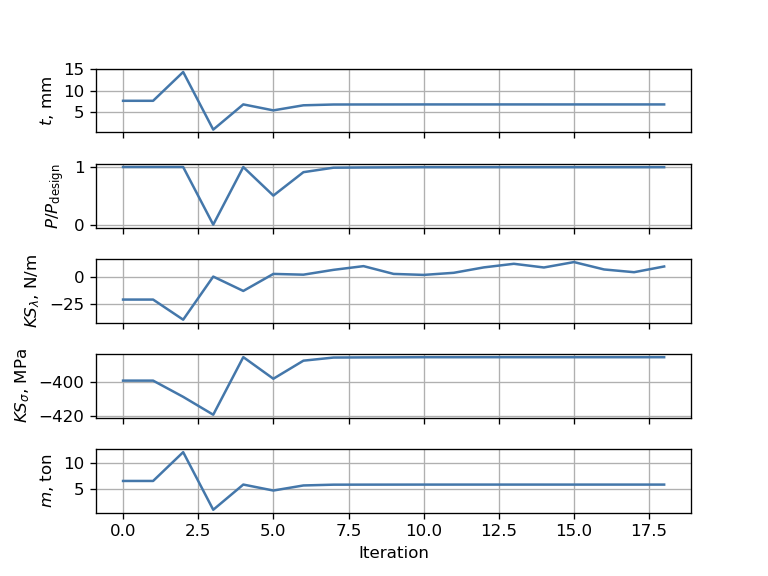

In [35]:
# Set default input values of sol_106 component
input_name = "sol_106_optimization3"
nonlinear_problem.model.options['input_name'] = input_name
nonlinear_problem.model.options['bdf_object'].loads[force_set_id][0].mag = DESIGN_LOAD  # apply design load

# Add recorder
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

# Plot optimization history
sol_106_opt_histories = plot_optimization_history(recorder_filepath)

Also in this case the optimization ends with an unfeasible design, so we look for the last feasible point and print the values of the design variable, contraints and objective.

In [36]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_percentage_variation = (sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
print(f"""Final thickness: {sol_106_opt_histories['nastran_solver.t'][feasible_design_index, 0]:.1f} mm
Final KS value of nonlinear structural stability: {sol_106_opt_histories['nastran_solver.ks_stability'][feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {sol_106_opt_histories['nastran_solver.ks_stress'][feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {sol_106_opt_histories['nastran_solver.applied_load'][feasible_design_index, 0]:.2f}
Mass variation: {mass_percentage_variation:.1f} %""")

Final thickness: 6.9 mm
Final KS value of nonlinear structural stability: -12.89 N/m
Final KS value for stress: -386 MPa
Final nondimensional applied load: 1.00
Mass variation: -10.9 %


This time we find a significantly larger reduction of the mass and of the margin of stability, suggesting that optimization did not end because the arc-length solver jumped on a complementary path, rather because it was not possible to find a better design point within the optimizer's tolerances.

To verify that the solver did not jump on a complementary path, we plot the eigenvalue and load-displacement diagrams of the last design, which is unfeasible.

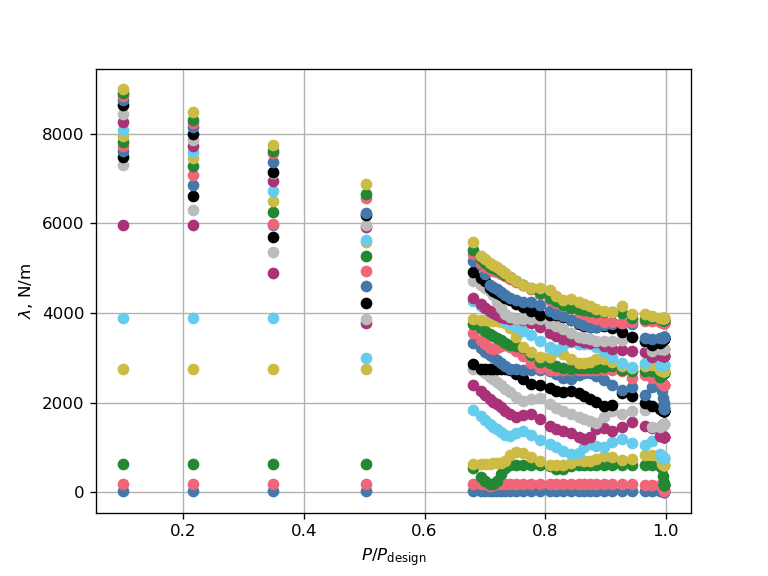

C:\Users\qa21944\AppData\Local\Temp\ipykernel_19772\3636366084.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


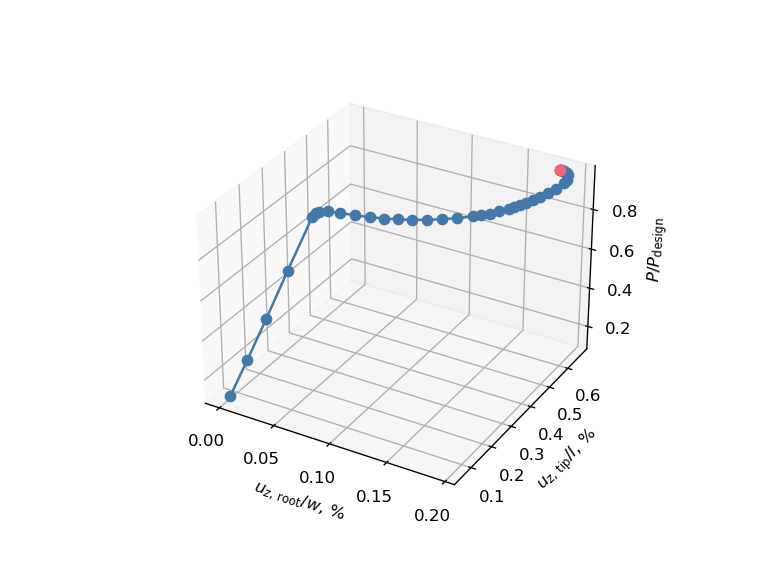

In [37]:
sol_106_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
plot_eigenvalues_and_load_displacement_diagrams(input_name, sol_106_op2)

We see that the arc-length solver successfully follows the equilibrium path through the broken supercritical pitchfork without jumping, until it finds the limit point.

Let's run the analysis of the last feasible point.

In [38]:
nonlinear_problem.model.nastran_solver.options['input_name'] = "sol_106_optimization3_feasible"  # change input name for analysis of initial structure
nonlinear_problem.set_val('nastran_solver.t', sol_106_opt_histories['nastran_solver.t'][feasible_design_index, 0])
nonlinear_problem.run_model()

Nastran job sol_106_optimization3_feasible.bdf completed
Wall time: 479.0 s


Before plotting the load-displacement diagram of the optimized structure, let's calculate the linear buckling load to show the glass ceiling of linear buckling.

subcase=1 already exists...skipping


Nastran job sol_105_optimization3_feasible.bdf completed
Wall time: 13.0 s
P_SOL 105/P_design = 0.71


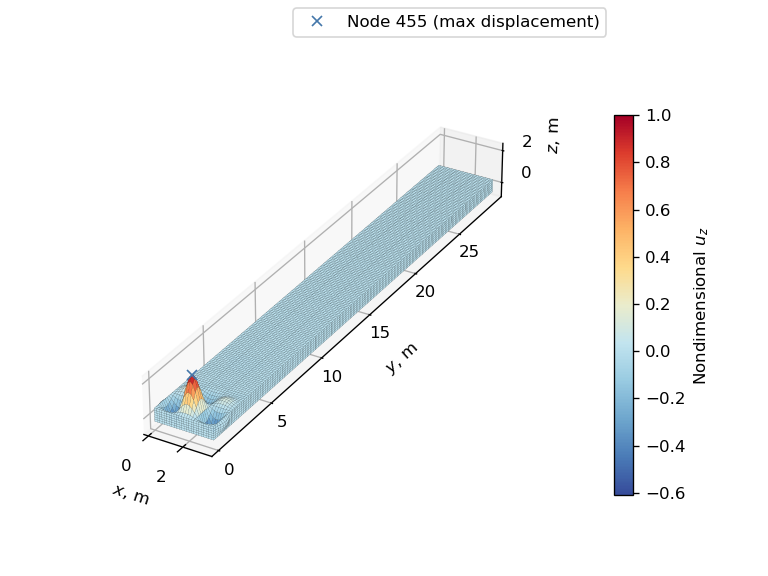

In [39]:
# Assign thickness of feasible design to PSHELL card
pid = 1
box_beam_bdf.properties[pid].t = sol_106_opt_histories['nastran_solver.t'][feasible_design_index, 0]

# Run SOL 105 and return OP2 object
input_name = "sol_105_optimization3_feasible"
sol_105_op2 = pynastran_utils.run_sol_105(bdf_object=box_beam_bdf, static_load_set_id=force_set_id,
                                          analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)

# Find critical buckling load
buckling_load_factor = sol_105_op2.eigenvectors[second_subcase_id].eigrs[0]
print(f"P_SOL 105/P_design = {buckling_load_factor:.2f}")

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Find node where max displacement occurs for critical mode
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[second_subcase_id].node_gridtype[max_displacement_index, 0]

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    second_subcase_id].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The above results show that the linear buckling load of the optimized structure is only 71% of the design load, demonstrating the idea of the glass ceiling of linear buckling. In fact, using linear structural stability methods, the optimized sturcture would not be deemed capable of withstanding the design load, whereas the nonlinear analysis suggests that the structure can carry the load without losing stability or failing in terms of material strength. Morover, we observe that the critical buckling mode of the optimized structure is totally analogous to that of the initial structure.

We further demonstrate the idea of the glass ceiling of linear buckling by plotting the load-displacement diagrams of the node at the root and at the tip of the CRM-like box beam, comparing the initial sturcture with the optimized structure.

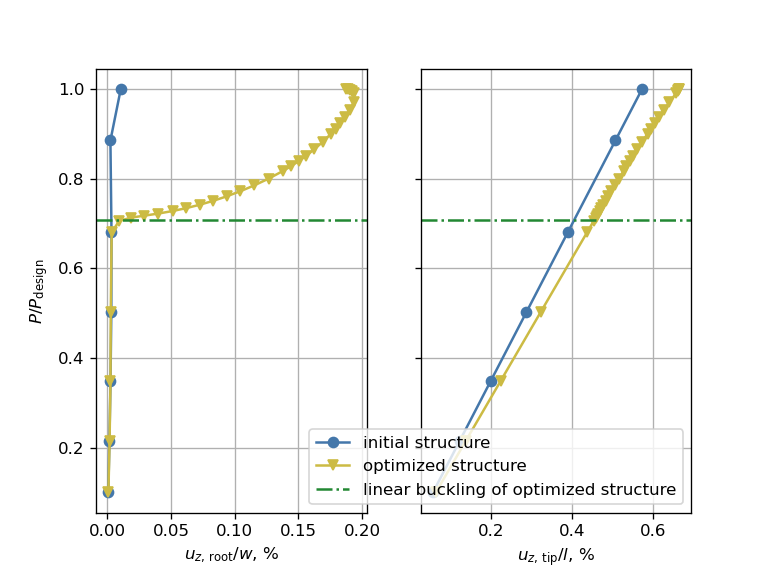

In [40]:
# Create figure with two subplots and initialize variables for the loops
fig, axes = plt.subplots(1, 2, sharey=True)
input_name_dict = {"initial structure": "sol_106_optimization_start",
                   "optimized structure": "sol_106_optimization3_feasible"}
sol_106_op2_dict = {}
reference_lengths = ["w", "l"]
stable_lines = []  # list to store proxy artists for the legend

# Iterate through the input names
for count, (design_key, input_name) in enumerate(input_name_dict.items()):
    # Read eigenvalues of tangent stiffness matrix
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
    eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Read load and displacement history
    sol_106_op2_dict[design_key] = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + ".op2"), load_geometry=True, debug=None)
    _, applied_loads, root_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2_dict[design_key], displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
    _, _, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2_dict[design_key], displacement_node_id=TIP_MASTER_NODE_ID)
    # Nondimensionalize loads and displacements
    nondimensional_loads = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
    nondimensional_displacements = {"root": root_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}
    # Plot load-displacement diagrams of the initial and linearly optimized structures
    for ax_index, displacement_key in enumerate(nondimensional_displacements):
        plot_utils.plot_2d_load_displacements_stability(eigenvalues, axes[ax_index],
                                                        nondimensional_displacements[displacement_key]*100,
                                                        nondimensional_loads, MARKERS[count], COLORS[count])
    # Create proxy artist for the legend
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=design_key))

# Set glass ceiling line, axis labels and grid of subplots
for ax_index, displacement_key in enumerate(nondimensional_displacements):
    axes[ax_index].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
    axes[ax_index].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_key}}}}}/{reference_lengths[ax_index]}$, %")  # set x-axis label
    axes[ax_index].grid(visible=True)  # show grid
axes[0].set_ylabel("$P/P_\mathrm{design}$")

# Add proxy artist for unstable lines, create legend and show plot
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of optimized structure")
axes[1].legend(handles=stable_lines + [glass_ceiling_line], loc="lower right")
plt.show()

The above plots show that the optimizer has successfully reduced the mass of the structure by decreasing the margin of structural stability at the design load so that the loss of stability occurs just above such load. The green line shows the load where the optimized structure would be considered to fail for buckling if analyzed with linear methods.

The root displacement diagram shows a large displacement for the optimized structure when compared to the initial one, in an analogous way as it was observed for the initial structure across the broken supercritical pitchfork. As far as the tip displacement diagram is concerned, we can observe that the optimized structure has a globally more compliant response, as it can be expected given the reduced wall thickness.

Given the large root displacement observed for the optimized structure, it is interesting to compare the deformation of the two structures at the design load.

Deformation at design load of initial structure:


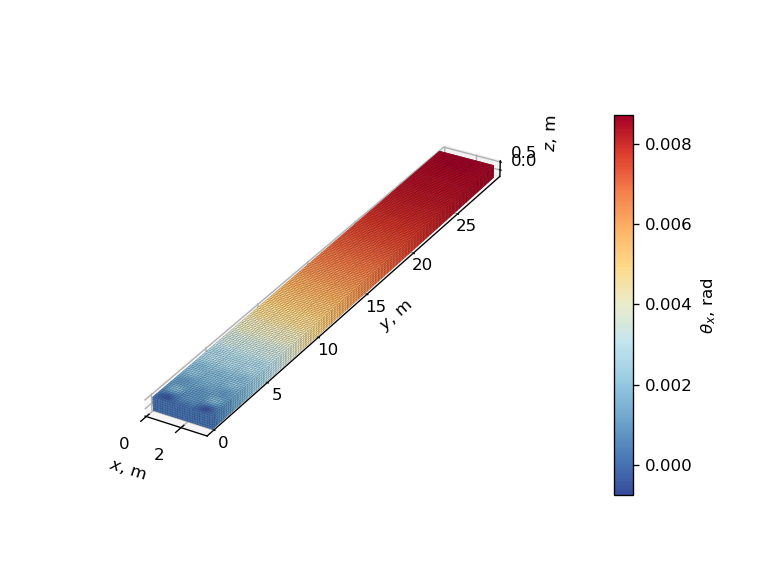

Deformation at design load of optimized structure:


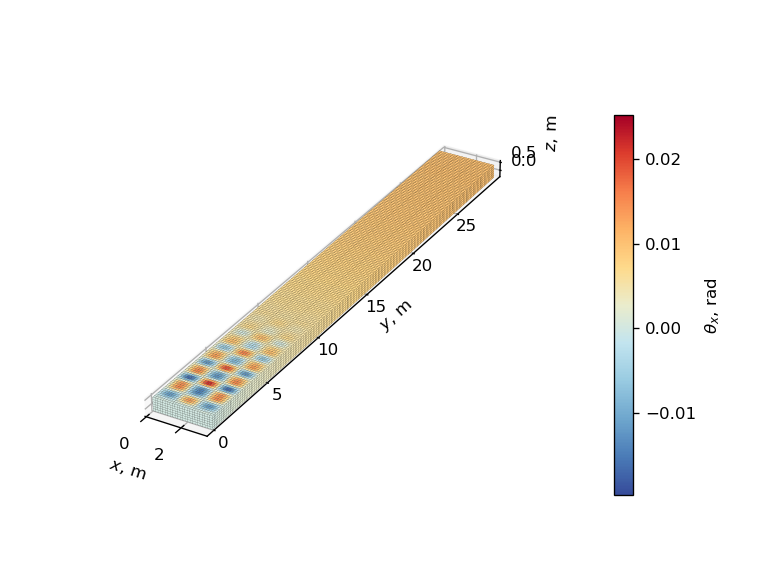

In [41]:
for key in sol_106_op2_dict:  # loop through the linearly and nonlinearly optimized structures
    print(f"Deformation at design load of {key}:")
    _, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[key], displacement_component='rx',
                                                          colormap='sunset', length_unit='m', unit_scale_factor=1e-3)  # plot deformation converting from mm to m
    adjust_3d_plot(ax, cbar)
    plt.show()

We can clearly observe that the deformation of the initial structure resembles the one of a beam under a linear deformation field, while the optimized structure shows a buckling-like pattern over the root region of the top skin.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have demonstrated how to set up and run a proof-of-concept optimization with a nonlinear structural stability constraint.

Initially, we have looked for a computationally efficient set of parameters for the nonlinear analysis, which allows to capture the unstable part of the equilibrium path of the structure without using very small arc-length increments. Successively, we have set up the optimization problem with OpenMDAO, defining the design variable, objective and constraints functions, and we have run the optimization with COBYLA. We further refined the parameters of the nonlinear analysis as we found that the arc-length solver was jumping to complementary paths during the analyses of the optimization, preventing the achievement of significative mass reductions. In this effort, we found out that reducing the maximum number of iterations for each arc-length increment to 3 was the most robust solution.

With the final set of parameters, we have run a final optimization, which resulted in a 10.9% mass reduction with respect to the initial design, which was optimal in linear buckling terms. In other words, the optimized structure resulted in a linear buckling load that is only 71% of the design load, demonstrating the idea of the glass ceiling of linear buckling. The mass reduction was achieved by reducing the margin of structural stability at the design load, so that the loss of stability occurs just above such load. The optimized structure shows a globally more compliant response, as it can be expected given the reduced wall thickness.

In our [next notebook](20_Two-variables_Optimization_of_the_CRM-like_Box_Beam.ipynb) we are going to increase the complexity of our optimization problem by considering two design variables defining a linear variation of the wall thickness from root to tip.